In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from torchvision.models.segmentation import deeplabv3_resnet50
import os
import cv2
import warnings
import numpy as np
from torchvision.transforms import ToPILImage
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
class Cat_Prediction():
    def __init__(self):
        """
        Cat Background Segmentation class using with ResNet50 backbone for PLASMICS.

        Attributes:
            model (torch.nn.Module): The pre-trained DeepLabV3 model with a ResNet50 backbone, loaded and ready for inference on GPU.
            preprocess (torchvision.transforms.Compose): Preprocessing pipeline for input images to be fed into the segmentation model.
        """
        self.model = deeplabv3_resnet50(pretrained=True).cuda()
        # Set the model to evaluation mode
        self.model.eval()
        self.preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
    def segment(self, image):
        """
        Segment the cat from the background in the input image.

        Inputs:
            image (str or PIL image): The input image to be segmented. It can be provided as either a file path or a PIL image object.

        Returns:
            PIL image: The segmented image, where the cat is separated from the background.

        Raises:
            FileNotFoundError: If the image file is not found at the specified path.

        Example usage:
            >>> segmenter = CatSegmenter()
            >>> segmented_image = segmenter.segment("path/to/input_image.jpg")
            >>> segmented_image.show()
        """
        # Load and preprocess the input image
        if isinstance(image, str):
            if not os.path.exists(image):
                raise FileNotFoundError("Image not found at {}".format(image))
            image = Image.open(image).convert("RGB")
            input_batch = self.preprocess(image).unsqueeze(0).cuda()
            
        elif isinstance(image, Image.Image):
            input_batch = self.preprocess(image).unsqueeze(0).cuda()
            
        else:
            raise TypeError("Image must be a PIL image or a path to an image file, but got {}".format(type(image)))
        
        # Run the image through the model
        with torch.no_grad():
            output = self.model(input_batch)['out'][0]

        # Post-process the output to obtain the segmentation mask
        output_predictions = output.argmax(0)
        
        # Convert the output predictions to a PIL image
        output_predictions = torch.where(output_predictions == 0, 0, 255)
        mask = transforms.ToPILImage()(output_predictions.byte())
        
        # Display the input image and the segmentation mask
        segment = Image.composite(image, Image.new('RGB', image.size), mask)
        return segment
    
    def display_image(self, image, titles):
        # sanity check
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")
        # Display the image
        plt.imshow(np.array(image))
        plt.title(titles)
        plt.show()

pred = Cat_Prediction()

In [4]:
def normalising(image):
    """
    Normalize the input image using histogram equalization. Histogram equalization is a technique used to enhance the contrast of an 
    image by redistributing the intensity values. 

    Inputs:
        image (str): The path to the input image file.

    Returns:
        PIL image: The normalized image as a PIL image object.
    """
    if not os.path.exists(image):
        raise FileNotFoundError("Image not found at {}".format(image))
    image = Image.open(image).convert("RGB")
    image = exposure.equalize_hist(np.array(image))
    image = Image.fromarray(image.astype(np.uint8))
    return image


def gaussian_denoise(image):
    """
    This is a function to denoise the image with gaussian
    
    Inputs:
        image (str): The path to the input image file.

    Returns:
        PIL image: The normalized image as a PIL image object.
    """
    denoize = cv2.GaussianBlur(cv2.imread(image), (11, 11), 20)
    denoize = Image.fromarray(denoize.astype(np.uint8))
    return denoize

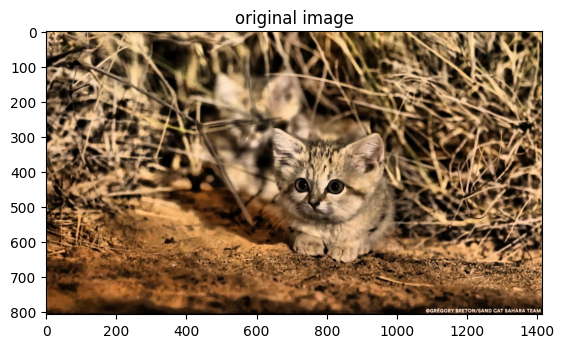

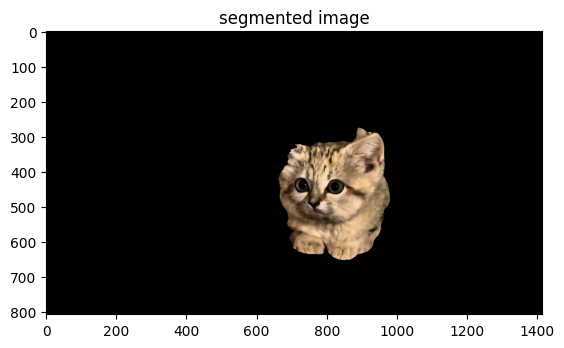

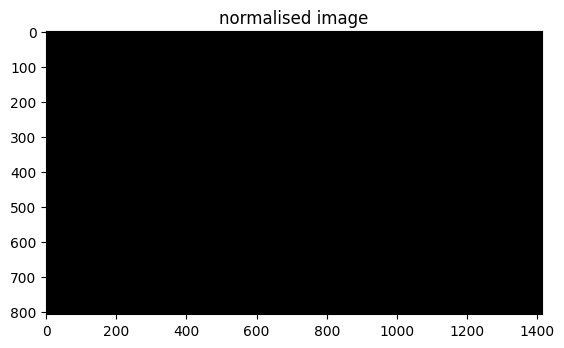

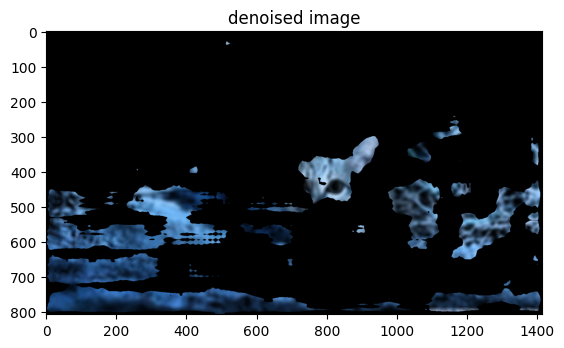

In [6]:
img = 'dataset/given_1.jpg'

# Prints Original Image
pred.display_image(img, 'original image')

# Prints output of original image prediciton from model
pred.display_image(pred.segment(img), 'segmented image')

# Prints output of normalised image prediciton from model
pred.display_image(normalising(img), 'normalised image')

# Prints output of denoised image prediciton from model
pred.display_image(pred.segment(gaussian_denoise(img)), 'denoised image')

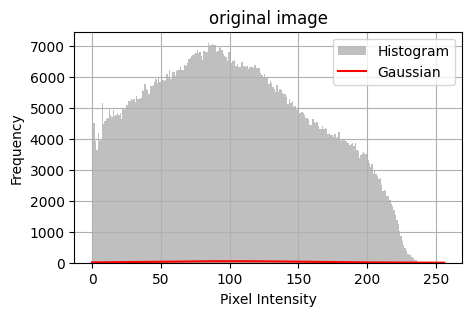

In [4]:
class Gaussian_Histogram():
    def __init__():
        pass
    
    def perform_gauss(image, title):
        if isinstance(image, str):
            image = Image.open(image).convert("L")
            image_array = np.array(image)
        elif isinstance(image, Image.Image):
            image_array = np.array(image)

        hist, bins = np.histogram(image_array.flatten(), bins=256, range=[0, 256])
        
        mu = np.mean(image_array)
        sigma = np.std(image_array)
        # Generate Gaussian filter
        gaussian_filter = gaussian(bins, mu, sigma)
        # Plot the histogram and the Gaussian filter
        plt.figure(figsize=(5, 3))
        plt.hist(image_array.flatten(), bins=256, range=[0, 256], color='gray', alpha=0.5, label='Histogram')
        plt.plot(bins, gaussian_filter * np.max(hist), color='red', label='Gaussian')
        plt.title(title)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()
        return None
        
    @staticmethod
    def gaussian(x, mu, sigma):
        return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
        
# Load the image
image_path = 'dataset/given_1.jpg'
Gaussian_Histogram.perform_gauss(image_path, 'original image')

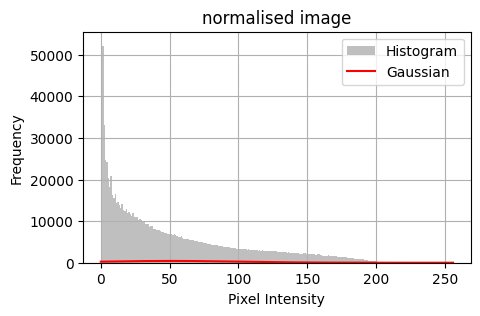

In [8]:
Gaussian_Histogram.perform_gauss('dataset/given_3.jpg', 'normalised image')